In [35]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import scipy as sp
from scipy import spatial
from multiprocessing import Pool
import merge_bubbles_v3 as merge
import merge_bubbles_v4_bounce as merge_bounce
import advect_bubbles as adv
import os


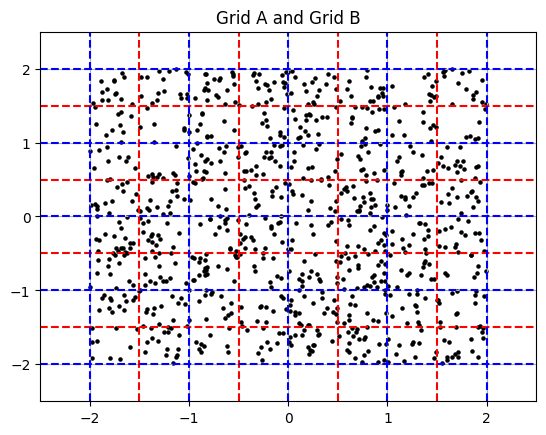

In [20]:
N_realisation = 3
np.random.seed(N_realisation)
N0_particle = 900
XP0 = np.random.uniform(-2, 2, N0_particle) 
YP0 = np.random.uniform(-2, 2, N0_particle)
# St0 = np.random.uniform(0.001, 2, N0_particle)

# XP0, YP0 = np.meshgrid(np.linspace(-2, 2, 30), np.linspace(-2, 2, 30))
# XP0, YP0 = np.meshgrid(XP0, YP0)
St0 = 0.5

R_collision = 0.05
merge_method = 'volume-weighted'
R0 = 1

path = 'velocity_results/alpha04_2D_geometry.npy'
x_core, y_core, y_core_lower, x_ring, y_ring = np.load(path, allow_pickle=True).T

xl, xr = -2, 2
yd, yu = -2, 2
dx_col, dy_col = 1, 1
Nx_col, Ny_col = 4, 4
gridA_xc, gridA_yc = np.meshgrid(np.linspace(xl+dx_col/2, xr-dx_col/2, Nx_col), np.linspace(yd+dy_col/2, yu-dy_col/2, Ny_col))
gridB_xc, gridB_yc = np.meshgrid(np.linspace(xl, xr, Nx_col+1), np.linspace(yd, yu, Ny_col+1))


# Plot gridA and gridB on the same figure
plt.figure()
for x, y in zip(gridA_xc[0],gridA_yc[:, 0]):
    plt.axhline(y, color='r', linestyle='--')
    plt.axvline(x, color='r', linestyle='--')

for x, y in zip(gridB_xc[0],gridB_yc[:, 0]):
    plt.axhline(y, color='b', linestyle='--')
    plt.axvline(x, color='b', linestyle='--')

plt.scatter(XP0, YP0, s=5, c='k')
plt.title('Grid A and Grid B')
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.grid()
plt.show()



In [21]:
Bubbles_df_ini = np.zeros((N0_particle, 11), dtype=np.float64)

# first column is bubbles ID
Bubbles_df_ini[:, 0] = np.arange(N0_particle)

# second column is bubbles X position
Bubbles_df_ini[:, 1] = XP0.flatten().astype(float)

# third column is bubbles Y position   
Bubbles_df_ini[:, 2] = YP0.flatten().astype(float)

# fourth column is bubbles x-velocity
Bubbles_df_ini[:, 3] = np.zeros(N0_particle)

# fifth column is bubbles y-velocity
Bubbles_df_ini[:, 4] = np.zeros(N0_particle)

# sixth column is bubbles Stokes number
Bubbles_df_ini[:, 5] = St0

# seventh column is bubbles slaved status
Bubbles_df_ini[:, 6] = False

# eighth column is bubbles gridA x-index
Bubbles_df_ini[:, 7] = np.floor((Bubbles_df_ini[:, 1] - xl ) / dx_col).astype(int)

# ninth column is bubbles gridA y-index
Bubbles_df_ini[:, 8] = np.floor((Bubbles_df_ini[:, 2] - yd ) / dy_col).astype(int)

# tenth column is bubbles gridB x-index
Bubbles_df_ini[:, 9] = np.floor((Bubbles_df_ini[:, 1]- xl + dx_col / 2) / dx_col).astype(int)

# eleventh column is bubbles gridB y-index	
Bubbles_df_ini[:, 10] = np.floor((Bubbles_df_ini[:, 2]- yd + dy_col / 2) / dy_col).astype(int)

# ditch the ones about to leave the domain 
Bubbles_df_ini = Bubbles_df_ini[(Bubbles_df_ini[:, 1] >= xl) & (Bubbles_df_ini[:, 1] < xr) 
                                & (Bubbles_df_ini[:, 2] >= yd) & (Bubbles_df_ini[:, 2] < yu)]

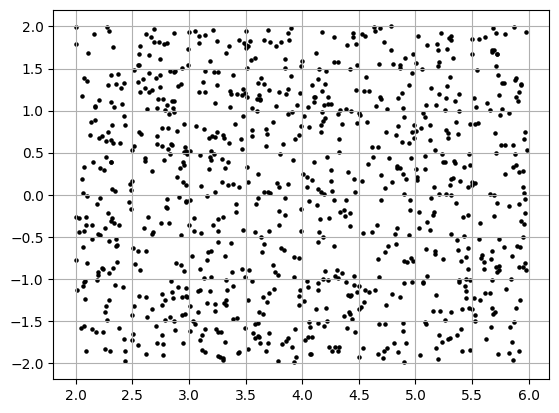

In [22]:
x_far = 6
x_res = np.linspace(xr, x_far, 100)
y_res = np.linspace(yd, yu, 100)
X_res, Y_res = np.meshgrid(x_res, y_res)

N0_particle_res = 900

# np.random.seed(N_realisation)
XP0_res = np.random.uniform(xr, x_far, N0_particle_res)
YP0_res = np.random.uniform(yd, yu, N0_particle_res)
St0_res = St0

plt.figure()
plt.scatter(XP0_res, YP0_res, s=5, c='k')
plt.grid(True)

Build a df from reservoir bubbles to track their Lagrangian trajectories\
All reservoir bubbles are released from rest and get advected by background flows

In [23]:
Res_df_ini_0 = np.zeros((N0_particle_res, 5), dtype=np.float64)

# first column is bubbles ID
Res_df_ini_0[:, 0] = np.arange(N0_particle_res) + N0_particle

# second column is bubbles X position
Res_df_ini_0[:, 1] = XP0_res.flatten().astype(float)

# third column is bubbles Y position
Res_df_ini_0[:, 2] = YP0_res.flatten().astype(float)

# fourth column is bubbles x-velocity
Res_df_ini_0[:, 3] = np.zeros(N0_particle_res)

# fifth column is bubbles y-velocity
Res_df_ini_0[:, 4] = np.zeros(N0_particle_res)

In [24]:
def supplement_reservoir(res_df_to_fill, N0_res_full, n_already_supplemented):
    
    # np.random.seed(N_realisation)
    
    # supplement the reservoir with new bubbles to maintain the total number of bubbles
    N_supplement = N0_res_full - res_df_to_fill.shape[0]

    # generate new bubbles
    new_bubbles_df = np.zeros((N_supplement, 5), dtype=np.float64)

    # first column is bubbles ID
    new_bubbles_df[:, 0] = np.arange(N_supplement) + n_already_supplemented + 10000

    # second column is bubbles X position
    new_bubbles_df[:, 1] = np.random.uniform((x_far + xr)/2, x_far, N_supplement)
    
    # third column is bubbles Y position
    new_bubbles_df[:, 2] = np.random.uniform(yd, yu, N_supplement)

    # fourth column is bubbles x-velocity
    new_bubbles_df[:, 3] = np.zeros(N_supplement)

    # fifth column is bubbles y-velocity
    new_bubbles_df[:, 4] = np.zeros(N_supplement)

    # concatenate the new bubbles to the reservoir
    res_df_to_fill = np.concatenate((res_df_to_fill, new_bubbles_df), axis=0)

    return res_df_to_fill, N_supplement

In [25]:
def create_injected_bubbles_df(injected_bubbles_df, St0_res):

    if len(injected_bubbles_df) > 0:
        # make a df for the injected bubbles and then extend it to the Bubbles_df_to_adv before calling merge
        injected_bubbles_df = np.hstack((injected_bubbles_df, np.zeros((len(injected_bubbles_df), 6), dtype=np.float64)))

        # sixth column is bubbles Stokes number
        injected_bubbles_df[:, 5] = St0_res

        # seventh column is bubbles slaved status
        injected_bubbles_df[:, 6] = False

        # # eighth column is bubbles gridA x-index
        # injected_bubbles_df[:, 7] = np.floor((injected_bubbles_df[:, 1] - xl ) / dx_col).astype(int)

        # # ninth column is bubbles gridA y-index
        # injected_bubbles_df[:, 8] = np.floor((injected_bubbles_df[:, 2] - yd ) / dy_col).astype(int)

        # # tenth column is bubbles gridB x-index
        # injected_bubbles_df[:, 9] = np.floor((injected_bubbles_df[:, 1]- xl + dx_col / 2) / dx_col).astype(int)

        # # eleventh column is bubbles gridB y-index
        # injected_bubbles_df[:, 10] = np.floor((injected_bubbles_df[:, 2]- yd + dy_col / 2) / dy_col).astype(int)

        # # ditch the ones about to leave the domain
        # injected_bubbles_df = injected_bubbles_df[(injected_bubbles_df[:, 1] >= xl) & (injected_bubbles_df[:, 1] <= xr)
        #                                         & (injected_bubbles_df[:, 2] >= yd) & (injected_bubbles_df[:, 2] < yu)]
        
        return injected_bubbles_df

Ux_avg = 0.07657459560006258 and supplement period is 5.224


/home/zhizhi/norbury_rings/merge_bubbles_v4_bounce.py:296: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  this_ax.scatter(update_bubbles_df[:, 1], update_bubbles_df[:, 2], s=marker_size**0.5, marker='o', c=color, linewidths=0)


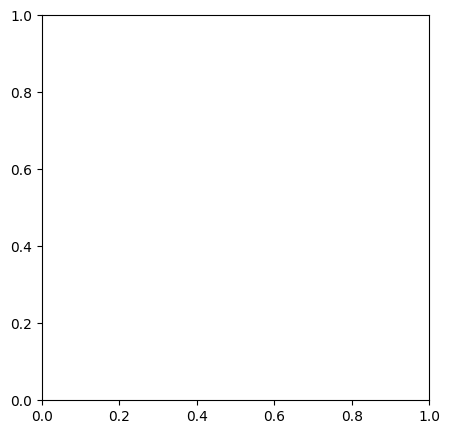

In [36]:
tNow = 0
dt = 0.02
tEnd = 5
st_lim = 7

N_tot = int((tEnd-tNow)/dt + 1)
N_mergeCycle = 0
N_feedCycle = N_tot
Nbub_already_supplemented = 0

Bubbles_df_after_merge = Bubbles_df_ini.copy()
Res_df_ini = Res_df_ini_0.copy()

# dist_hist = [Bubbles_df_after_merge[:, 5]]

V, H = np.mgrid[0:1:251j, 0:1:251j]
colors_hsv = np.dstack((H, np.ones_like(H), V))
colors_rgb = hsv_to_rgb(colors_hsv)

# define plotting handle
fig_1, ax = plt.subplots(1, 1, figsize=(5, 5))
# plt.scatter(Bubbles_df_after_merge[:, 1], Bubbles_df_after_merge[:, 2], s=0.1, c='b')
# ax.plot(x_core, y_core,'--',color='k', alpha=0.1)
# ax.plot(x_core, y_core_lower,'--',color='k', alpha=0.1)
# ax.plot(x_ring, y_ring, '--',color='k', alpha=0.1)

# create a list to store the bubble distribution history
collision_series = []
masters_slaves_series = []
folder_path = 'influx_random_sims_contInjection/temp'


while tNow < tEnd :
    
    if len(Res_df_ini) > 0:
        # advect randomly seeded bubbles in the reservoir
        updated_states_res = adv.advect_reservoir_bubbles(Res_df_ini, St0_res, tNow, tNow+dt, False)

        # update the ORIGINAL reservoir df 
        # create a df for the injected bubbles and then extend it to the Bubbles_df_to_adv before calling merge
        # then remove the injected bubbles from the reservoir
        Res_df_ini[:, 1:5] = updated_states_res
        injected_bubbles_df = Res_df_ini[updated_states_res[:, 0] <= xr]
        Res_df_ini = Res_df_ini[updated_states_res[:, 0] > xr]


        # for the first cycle, estimate the average axial velocity of bubbles in the reservoir, mean(V_x,res):
        if N_mergeCycle == 0:
            Ux_avg = np.abs(np.mean(Res_df_ini[:, 3]))

            # calculate the time step for supplementing the UPSTREAM HALF of reservoir bubbles
            dt_supplement = 0.1*(x_far - xr) / Ux_avg   # was 0.3 before

            # initiate the next supplement cycle
            N_feedCycle = N_mergeCycle + int(dt_supplement / dt)

            print('Ux_avg = {} and supplement period is {:.3f}'.format(Ux_avg, dt_supplement))

            
        if N_mergeCycle == N_feedCycle:
            # feed the EMPTY UPSTREAM HALF of reservoir bubbles 
            Res_df_ini, N_newly_added = supplement_reservoir(Res_df_ini, N0_particle_res, Nbub_already_supplemented)

            # calculate the NEXT FEED Cycle needed to feed the reservoir bubbles
            N_feedCycle = N_mergeCycle + int(dt_supplement / dt)

            # update the number of times the reservoir has been supplemented
            Nbub_already_supplemented += N_newly_added

            print('{} bubbles have been added to the reservoir, \n next cycle of supplement at {:.2f}'.format(N_newly_added, N_feedCycle))
        
        # # plot the reservoir bubbles distribution
        # fig = plt.figure(figsize=(5, 5))
        # plt.scatter(Res_df_ini[:, 1], Res_df_ini[:, 2], s=0.1, c='b')
        # plt.xlim(2, 6)
        # plt.ylim(-2, 2)
        # plt.grid(True)
        # plt.axis('equal')
        # plt.title('{} bubbles in the reservoir at t={:.3f}, \n next supplement cycle at t={} '.format(len(Res_df_ini), tNow, N_feedCycle*dt))
        # # plt.savefig(folder_path+'/reservoir_{}.png'.format(N_mergeCycle), dpi=300)
        # plt.show()
        

        # feed the reservoir bubbles into the domain
        N_injected = np.sum((updated_states_res[:, 0] <= xr))
        updated_states_injected = updated_states_res[updated_states_res[:, 0] <= xr]


        # advect Bubbles_df_to_adv
        Bubbles_df_to_adv = Bubbles_df_after_merge.copy()
        updated_states = adv.advect_bubbles(Bubbles_df_to_adv, t0=tNow, tf=tNow+dt, 
                                            plot_path= False, this_ax=ax, color=colors_rgb[N_mergeCycle, N_mergeCycle, :])

        # expand the injected bubbles df to the same size as the advected bubbles df
        injected_bubbles_df = create_injected_bubbles_df(injected_bubbles_df, St0_res)


        if injected_bubbles_df is not None:
            # stack the df's of the bubbles in the domain and the injected bubbles together
            Bubbles_df_before_merge = np.vstack((Bubbles_df_to_adv, injected_bubbles_df))
            total_updated_states = np.vstack((updated_states, updated_states_injected))
        else:
            Bubbles_df_before_merge = Bubbles_df_to_adv
            total_updated_states = updated_states

        # merge bubbles
        # Bubbles_df_after_merge, collision_list, masters_slaves_list = merge.merge_package(Bubbles_df_before_merge= Bubbles_df_before_merge, advected_states=total_updated_states, 
        #                                                 gridA_size=gridA_xc.shape, gridB_size=gridB_xc.shape,
        #                                                 boundaries=(xl, xr, yd, yu), cell_size=(dx_col, dy_col), R_collision=R_collision, st_lim=st_lim,
        #                                                 merge_method=merge_method,
        #                                                 timeNow=tNow, this_ax=ax, color=colors_rgb[N_mergeCycle, N_mergeCycle, :])
        
        Bubbles_df_after_merge, collision_list, masters_slaves_list = merge_bounce.merge_package(Bubbles_df_before_merge= Bubbles_df_before_merge, advected_states=total_updated_states, 
                                                        gridA_size=gridA_xc.shape, gridB_size=gridB_xc.shape,
                                                        boundaries=(xl, xr, yd, yu), cell_size=(dx_col, dy_col), R_collision=R_collision, st_lim=st_lim, R_bounce=R_collision,
                                                        merge_method=merge_method,
                                                        timeNow=tNow, this_ax=ax, color=colors_rgb[N_mergeCycle, N_mergeCycle, :])
    else:
        # advect Bubbles_df_to_adv
        Bubbles_df_to_adv = Bubbles_df_after_merge.copy()
        updated_states = adv.advect_bubbles(Bubbles_df_to_adv, t0=tNow, tf=tNow+dt, 
                                            plot_path= False, this_ax=ax, color=colors_rgb[N_mergeCycle, N_mergeCycle, :])
        Bubbles_df_before_merge = Bubbles_df_to_adv.copy()

        # merge bubbles
        # Bubbles_df_after_merge, collision_list, masters_slaves_list = merge.merge_package(Bubbles_df_before_merge= Bubbles_df_to_adv, advected_states=updated_states, 
        #                                                 gridA_size=gridA_xc.shape, gridB_size=gridB_xc.shape,
        #                                                 boundaries=(xl, xr, yd, yu), cell_size=(dx_col, dy_col), R_collision=R_collision, st_lim=st_lim,
        #                                                 merge_method=merge_method,
        #                                                 timeNow=tNow, this_ax=ax, color=colors_rgb[N_mergeCycle, N_mergeCycle, :])
        Bubbles_df_after_merge, collision_list, masters_slaves_list = merge_bounce.merge_package(Bubbles_df_before_merge= Bubbles_df_to_adv, advected_states=updated_states, 
                                                        gridA_size=gridA_xc.shape, gridB_size=gridB_xc.shape,
                                                        boundaries=(xl, xr, yd, yu), cell_size=(dx_col, dy_col), R_collision=R_collision, st_lim=st_lim, R_bounce=R_collision,
                                                        merge_method=merge_method,
                                                        timeNow=tNow, this_ax=ax, color=colors_rgb[N_mergeCycle, N_mergeCycle, :])
    
    collision_series.append(collision_list)
    if len(masters_slaves_list) > 0:
        masters_slaves_series.append(masters_slaves_list)
    else:
        masters_slaves_series.append(None)
    tNow += dt
    N_mergeCycle += 1 
    

    # if N_mergeCycle == N_tot-1:
    #     plt.savefig(folder_path+'/Final-realisation_{}.png'.format(N_realisation), dpi=300)

    plt.savefig(folder_path+'/frame_{}.png'.format(N_mergeCycle), dpi=300)
    np.save(os.path.join(folder_path, 'frame_{}.npy'.format(N_mergeCycle)), Bubbles_df_after_merge[:, :6])
    plt.close()
    # plt.show()

#     # plt.show here to make a new figure for each merging step
# # if N_mergeCycle % 10 == 0:
# #     plt.sca(ax_1)
# #     # plt.scatter(Bubbles_df_after_merge[:, 1], Bubbles_df_after_merge[:, 2], s=1, c='r')

# #     if (N_mergeCycle + 1) == N_tot:
# #         plt.savefig('final.png', dpi=300)

# #     plt.show()

# # trapped_bubbles_hist(Bubbles_df_after_merge, R0)


    
# # bubble_dist_history.append(Bubbles_df_after_merge[:, 5])

# np.save(os.path.join(folder_path, 'final_distribution_{}.npy'.format(N_realisation)), Bubbles_df_after_merge)

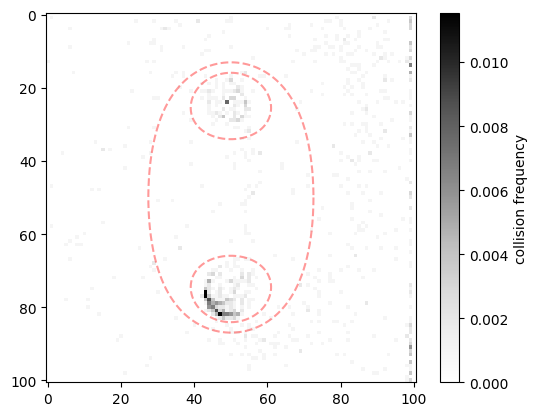

In [38]:
collision_box = {(x, y): 0 for x in range(101) for y in range(101)}

for collision in collision_series:
    x_s = np.asarray([c[0] for c in collision])
    y_s = np.asarray([c[1] for c in collision])
    j_s = np.floor((x_s - xl) / 0.04).astype(int)
    i_s = np.floor((y_s - yd) / 0.04).astype(int)

    # Combine i_s and j_s into a single array of coordinates
    coordinates = np.column_stack((i_s, j_s))

    # Use NumPy's unique function to get unique (i, j) pairs and their counts
    unique_coordinates, counts = np.unique(coordinates, axis=0, return_counts=True)

    # Create a dictionary from unique_coordinates and counts
    coll_box_counts = dict(zip(map(tuple, unique_coordinates), counts))

    for (i, j), count in coll_box_counts.items():
        collision_box[(i, j)] += count

counts_array = np.array(list(collision_box.values())).reshape(101, 101)
plt.imshow(counts_array[::-1, :]/np.sum(counts_array), cmap='Greys', interpolation='nearest')
plt.plot((x_core+2)/0.04, (y_core+2)/0.04, '--', color='r', alpha=0.4)
plt.plot((x_core+2)/0.04, (y_core_lower+2)/0.04, '--', color='r', alpha=0.4)
plt.plot((x_ring+2)/0.04, (y_ring+2)/0.04, '--', color='r', alpha=0.4)
plt.colorbar(label='collision frequency')
plt.savefig(os.path.join(folder_path, 'collision_frequency.jpg'), dpi=300)

plt.show()

import pickle

with open(os.path.join(folder_path, 'collision_series.pkl'), 'wb') as f:
    pickle.dump(collision_series, f)

with open(os.path.join(folder_path, 'masters_slaves_series.pkl'), 'wb') as f:
    pickle.dump(masters_slaves_series, f)